# pyPCGA tutorial example - pumping history identification

## (2) nonlinear (quasi-linear) inversion example (from Stanford 362G course)

### Please read the problem description in [(1) linear inversion example](./linear_inverse_problem_pumping_history_identification.ipynb)

+ Now we get to know that the unknown pumping rate cannot be **negative**: the owner of the well at (0,0) extracts groundwater when (s)he needs with no injection.
+ This prior information/constraint can be incorporated in the inversion by various methods. 
+ Our implementation here is to use log-transformation in order to enforce the nonnegativity constraint.
+ In other words, instead of the unknown pumping rate, q, we will work with $s = \ln(q)$.

---

$$ y = H \exp(s) $$

where $y$ is n by 1 drawdowns at the montoring well, 

$H$ is a m by m matrix/linear operator, 

$s$ is a m by 1 vector for the log-transformed pumping rates


---

### Test enviroment information

In [1]:
import sys
print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [2]:
import platform
print(platform.platform())


Windows-10-10.0.17134-SP0


In [3]:
import numpy as np
print(np.__version__)

1.14.0


In [4]:
import matplotlib.pyplot as plt
import drawdown as dd # our forward model interface
from pyPCGA import PCGA # PCGA ver0.1
import math

pyPCGA parameters (see [PCGA_parameters.docx](https://github.com/jonghyunharrylee/pyPCGA/blob/master/PCGA_parameters_06212018.docx) for details) 

Note that prior parameters (prior_std and prior_cov_scale) and measurement/model uncertainty (R) were estimated using a model validation approach [Kitanidis, 2007]

|Description           |                      |   Value | 
| ---------------------|----------------------|---------|
|*Geostatistical parameters*     ||                     |
| prior_std            | (Bayesian) prior uncertainty/standard deviation | 1.0 [$m^3$/min]|
| prior_cov_scale      | Prior scale/correlation length                        | 100 m |
| kernel        | Covariance kernel q(x,x') | q(x,x') = $1.0^2 \exp\left(-|x-x'|/100\right)$|
| m                    | Number of unknowns (unknown pumping history over time) | 10,001 |
| matvec               | Fast covariance matrix-vector multiplication method | FFT (will support Hmatrix/FMM in ver 0.2)| 
| N                    | Array of grid numbers in each direction ([nx,ny,nz], for structured grid/FFT)  | [10,001] (1D) |
| xmin, xmax           | Array of min and max coordinates in each direction (for structured grid/FFT)  | [0], [1000] (1D) |
| pts                  | Coordinates for unknowns (optional, used for Hmatrix and FMM) | [0, 0.1. 0.2, ..., 999.9 1000 ] |
| post_cov             | Posterior uncertainty (variance/covaraiance, currently support posterior variance)      | diag |
|*Measurement parameters* ||  |
| nobs | Number of measurement | 100 |
| R | Variance of measurement error (and model uncertainty) (m) | 0.02^2 |
|*Inversion parameters* || |
| maxiter | Maximum iteration number | 10|
| restol | Tolerance (relative norm differnce) for stopping criteria | 0.01|
| parallel | Use parallelization for inversion | True|
| ncores | number of cores if parallel == True | None (if not defined, use all the physcial cores you have)|
|precond | Use preconditioner | True |
|LM | Use Levenberg-Marquardt |  True|
| linesearch | Use linearseach | True|
| verbose | Inversion message |  False|
| forward_model_verbose | user-define forward model message |  False|
| iter_save | Save intermediate solutions | True |




+ Model domain and discretization

In [5]:
# model domain and discretization
m = 10001 # number of unknowns (unknown pumping rates over the time) 
N = np.array([m]) # discretization grids in each direction [nx,ny,nz] m = nx*ny*nz; for this 1D case, N = nx = [m]
xmin = np.array([0]) # min x, y, z;  for this 1D case, min(x) = min(t)
xmax = np.array([1000]) # max x, y, z; for this 1D case, max(x) = max(t)

+ Covariance kernel and scale parameters

In [6]:
# covairance kernel and scale parameters
# now that we have different estimation variable (log-transformed extraction rate), these prior parameters should be redefined
prior_std = 1.0
prior_cov_scale = np.array([100.0])

def kernel(r): return (prior_std ** 2) * np.exp(-r)

+ Load "true" pumping history

In [7]:
s_true = np.loadtxt('true.txt') 

Text(0,0.5,'s ($m^3$/min)')

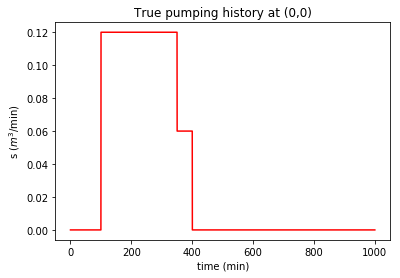

In [8]:
# for plotting
x = np.linspace(xmin, xmax, m)
pts = np.copy(x)

plt.plot(x,s_true,'r-',label='true')
plt.title('True pumping history at (0,0)')
plt.xlabel('time (min)')
plt.ylabel(r's ($m^3$/min)')

+ Load 100 noisy observations recorded at every 10 mins (see drawdown.py)
```python
obs = np.dot(H,s_true) + 0.01*np.random.randn(m,1)
```

In [9]:
obs = np.loadtxt('obs.txt')

+ Define a wrapper for a black-box forward model input in pyPCGA 

##### 1. Note that one should follow this wrapper format to work with pyPCGA 
##### 2. If parallelization == True, it should take multiple columns of s and run the forward problem independently in parallel
##### 3. Please see drawdown.py as a template for inplementation

In [10]:
# forward model wrapper for pyPCGA
def forward_model(s, parallelization, ncores=None):
    params = {'log':True} # y = np.dot(H,np.exp(s)); see drawdown.py 
    model = dd.Model(params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
    return simul_obs

+ Inversion parameters 

In [11]:
params = {'R': (0.02) ** 2, 'n_pc': 100,
        'maxiter': 10, 'restol': 0.01,
        'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
        'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
        'kernel': kernel, 'post_cov': "diag",
        'precond': True, 'LM': True,
        'parallel': True, 'linesearch': True,
        'forward_model_verbose': False, 'verbose': False,
        'iter_save': True}

# params['objeval'] = False, if true, it will compute accurate objective function
# params['ncores'] = 4, with parallell True, it will determine maximum physcial core unless specified

+ Initial guess

In [12]:
s_init = -1. * np.ones((m, 1)) # or any initial guess you want 

## Inversion

+ Initialize pyPCGA

In [13]:
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 10001
   Number of observations                           : 100
   Number of principal components (n_pc)            : 100
   Prior model                                      : def kernel(r): return (prior_std ** 2) * np.exp(-r)

   Prior variance                                   : 1.000000e+00
   Prior scale (correlation) parameter              : [100.]
   Posterior cov computation                        : diag
   Posterior variance computation                   : Direct
   Number of CPU cores (n_core)                     : 4
   Maximum GN iterations                            : 10
   machine precision (delta = sqrt(precision))      : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-02
   Levenberg-Marquardt (LM)                         : True
   LM solution range co

+ Run pyPCGA

In [14]:
# run inversion
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 10001) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 100 is 1 sec
- 1st eigv : 1870.85, 100-th eigv : 2.06516, ratio: 0.00110386
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 6.96206, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 348.103
***** Iteration 1 ******
computed Jacobian-Matrix products in 0.907606 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
LM solution evaluted
- Geostat. inversion at iteration 1 is 2 sec
== iteration 1 summary ==
= objective function is 7.429391e+05, relative L2-norm diff btw sol 0 and sol 1 is 0.920778
= L2-norm error (w.r.t truth) is 3169.54, obs. RMSE is 2.43793, obs. normalized RMSE is 121.897
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 1.27837

### Yes, this is so simple! You only need 2 lines of code (initialization, run) for inversion

Log-transformation of unknown pumping rates makes the problem nonlinear and this requires several iterations. But we don't need to worry about negative extraction (injection) in our solution and the non-negativity constraint reflecting our confident prior knowledge results in a better fitting (observation matching) as below in Figure 2 (compared to [the linear inversion result](./linear_inverse_problem_pumping_history_identification.ipynb#Results)). 

However, this kind of transformation may lead to highly non-symmetric pdf in the original/untransformed space. For example, even though we would think the uncertainty of the estimated pumping rates over the time should be of the same magnitude as we observed in [the linear problem](./linear_inverse_problem_pumping_history_identification.ipynb#Results), the Bayesian credible interval becomes narrow for low values and wide for high values due to the log-transformation as below in Figure 1. 

## Results

- Plot the best (mean) estimate and its uncertainty interval

Text(0.5,1,'Figure 1: Estimate with Bayesian credible interval')

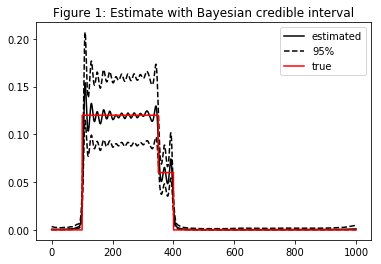

In [15]:
# plot posterior uncertainty/std
# back tansform
s_hat_real = np.exp(s_hat)
post_std = np.sqrt(post_diagv)
s_hat_upper = np.exp(s_hat + 1.96*post_std)
s_hat_lower = np.exp(s_hat - 1.96*post_std)

fig = plt.figure()
plt.plot(x,s_hat_real,'k-',label='estimated')
plt.plot(x,s_hat_upper,'k--',label='95%')
plt.plot(x,s_hat_lower,'k--',label='')
plt.plot(x,s_true,'r-',label='true')
plt.legend()
plt.title('Figure 1: Estimate with Bayesian credible interval')


+ Plot observation mismatch

(-1, 3)

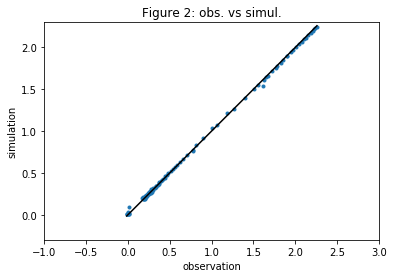

In [16]:
plt.title('Figure 2: obs. vs simul.')
plt.plot(prob.obs, simul_obs, '.')
plt.xlabel('observation')
plt.ylabel('simulation')
minobs = np.vstack((prob.obs, simul_obs)).min(0)
maxobs = np.vstack((prob.obs, simul_obs)).max(0)
plt.plot(np.linspace(minobs, maxobs, 20), np.linspace(minobs, maxobs, 20), 'k-')
plt.axis('equal')
axes = plt.gca()
axes.set_xlim([math.floor(minobs), math.ceil(maxobs)])
axes.set_ylim([math.floor(minobs), math.ceil(maxobs)])
